SETUP

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
os.chdir('..')
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")   # Run only if necessary

from src.data.Dataset import Dataset as DS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

DATASET

In [4]:
# Dataset generator

n = 10
m = 5
hop = 1/1200
input_dim   = 30 * n
pred_dim    = 0.25
shift       = pred_dim
batch_size  = 256
Data        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll','heave','pitch','wave']
                )

In [5]:
Data.Train.element_spec

(TensorSpec(shape=(None, 1200, 4), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))

In [6]:
INPUT_DIM = Data.xshape
OUTPUT_DIM = Data.yshape

print('Input dim:', INPUT_DIM)
print('Output dim:', OUTPUT_DIM)

Input dim: [1200, 4]
Output dim: [1, 1]


MODEL

In [16]:
# Loss functions

# Regression loss
MSE_loss = tf.keras.losses.MeanSquaredError()
MAE_loss = tf.keras.losses.MeanAbsoluteError()
MAPE_loss = tf.keras.losses.MeanAbsolutePercentageError()

# Metrics

# Regression metrics
MAPE = tf.keras.metrics.MeanAbsolutePercentageError()
MAE = tf.keras.metrics.MeanAbsoluteError()
MSE = tf.keras.metrics.MeanSquaredError()

In [8]:
# norm = tf.keras.layers.Normalization(input_shape=INPUT_DIM, axis=-1)
# x_ds = Data.Train.map(lambda x, y: x)
# norm.adapt(x_ds)

In [17]:
# Define model here

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_DIM),
    tf.keras.layers.LSTM(units=256, return_sequences=True),
    tf.keras.layers.LSTM(units=64, return_sequences=False),
#     tf.keras.layers.LSTM(units=32, return_sequences=False),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(OUTPUT_DIM[0])
])

In [18]:
# Compile model

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=MAPE_loss, metrics=[MSE, MAE])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1200, 256)         267264    
                                                                 
 lstm_3 (LSTM)               (None, 64)                82176     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 351,553
Trainable params: 351,553
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Check if model is working and the output shape
Data.batch_size = 256

for x, y in Data.Train.take(1):
    out = model(x)
    print(out.shape)

(256, 1)


TRAINING

In [20]:
# Defining the required callbacks
from datetime import datetime

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=7,
                                                    mode='min')

checkpoint_filepath = 'models/RNN/10/model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001)

logdir = "models/RNN/10/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, update_freq=500)

In [21]:
logdir = 'models/RNN/10/metrics'

%tensorboard --logdir models/RNN/10/logs

Reusing TensorBoard on port 6006 (pid 21972), started 0:01:20 ago. (Use '!kill 21972' to kill it.)

In [22]:
# Model training

history = model.fit(Data.Val, epochs=100, validation_data=Data.Test, callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback])

Epoch 1/100
    994/Unknown - 513s 513ms/step - loss: 2093.8301 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0308

INFO:tensorflow:Assets written to: models/RNN/10\model\assets


INFO:tensorflow:Assets written to: models/RNN/10\model\assets


994/994 [==============================] - 894s 898ms/step - loss: 2093.8301 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0308 - val_loss: 115.6083 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0307
Epoch 2/100
994/994 [==============================] - 884s 890ms/step - loss: 881.0699 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0297 - val_loss: 142.7974 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0304
Epoch 3/100
994/994 [==============================] - 884s 890ms/step - loss: 829.2798 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0289 - val_loss: 310.7855 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0299
Epoch 4/100
994/994 [==============================] - 897s 903ms/step - loss: 696.5662 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0284 - val_loss: 124.7375 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0302
Epoch 5/100
994/994 [==============================] - 898s 904ms/step 

In [46]:
# Save model
# Uncomment to save model

model_save_dir = 'models/RNN/05r/model'

model.save(model_save_dir)

INFO:tensorflow:Assets written to: models/RNN/05r/model\assets


INFO:tensorflow:Assets written to: models/RNN/05r/model\assets


IMPORTING SAVED MODEL

In [6]:
# Load model

model_dir = 'models/RNN/04/model'

model = tf.keras.models.load_model(model_dir)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1200, 128)         68096     
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 199,809
Trainable params: 199,809
Non-trainable params: 0
_________________________________________________________________


MODEL PERFORMANCE

In [ ]:
# Evaluate model

val_performance = model.evaluate(Data.Val)
test_performance = model.evaluate(Data.Test)

print('Validation MSE_loss: {:.2f}'.format(val_performance[0]))
print('Validation MAPE:     {:.2f}'.format(val_performance[1]))
print('Validation MAE:      {:.2f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.2f}'.format(test_performance[0]))
print('Test MAPE:           {:.2f}'.format(test_performance[1]))
print('Test MAE:            {:.2f}'.format(test_performance[2]))

INFERENCE

In [4]:
# Dataset generator
n = 10
m = 5
hop = 0.5
input_dim   = 30 * n
pred_dim    = 30 * n
shift       = pred_dim
batch_size  = 16
Data_inf        = DS(
                input_dim, 
                pred_dim, 
                shift, 
                skip=0.25, 
                hop=hop, 
                batch_size=batch_size,
                in_cols=['roll','heave','pitch','wave'],
                out_cols=['roll','heave','pitch','wave']
                )

In [11]:
def ARModel_Inference(x, y, OUT_dim = pred_dim*4, model=model):
    inp1 = x
    true_roll = y[:,:,0]
    pred_roll = []
    for i in range(OUT_dim):
        wave = y[:,i:i+1,-1:]
        INPUT = inp1
        OUT = model(INPUT)
        roll = tf.expand_dims(tf.cast(OUT, tf.float64), axis=1)
        HPW = y[:,i:i+1,1:]
        temp = tf.concat([roll, HPW], axis = -1)
        inp1 = tf.concat([inp1[:,1:,:], temp], axis=1)
        pred_roll.append(roll[:,:,0])

    pred_roll = tf.squeeze(tf.stack(pred_roll, axis=1), [-1]) 
    return true_roll, pred_roll


def get_inference(Data_inf, model=model, OUT_dim = pred_dim*4, save_dir=None):
    true_roll = []
    pred_roll = []
    inputs = []
    for x, y in Data_inf.take(20):
        t_r, p_r = ARModel_Inference(x, y, OUT_dim = OUT_dim, model=model)
        pred_roll.extend(p_r)
        true_roll.extend(t_r)
        inputs.extend(x)
        
    inputs = np.array(inputs)
    true_roll = np.array(true_roll)
    pred_roll = np.array(pred_roll)
        
    return inputs, true_roll, pred_roll
    
def save_inference(inputs, true_roll, pred_roll, save_dir):
    
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
        
    inp_path = save_dir + '/inputs.csv'
    true_path = save_dir + '/true_roll.csv'
    pred_path = save_dir + '/pred_roll.csv'

    np.savetxt(inp_path, inputs[:,:,0], delimiter =", ")
    np.savetxt(true_path, true_roll, delimiter =", ")
    np.savetxt(pred_path, pred_roll, delimiter =", ")
    
def load_inference(folder):
    inputs    = np.genfromtxt(folder + '/inputs.csv', delimiter=', ', skip_header=0)
    true_roll = np.genfromtxt(folder + '/true_roll.csv', delimiter=', ', skip_header=0)
    pred_roll = np.genfromtxt(folder + '/pred_roll.csv', delimiter=', ', skip_header=0)
    
    return inputs, true_roll, pred_roll


In [8]:
def plot_inference(inputs, true, pred, nos, cut=0.5, units='deg'):
    n = inputs.shape[-1]
    n_plots = len(nos)
    cut_ind = int(n*cut)
    
    fac = 180/np.pi if units=='deg' else 1
    
    plt.figure(figsize=(18, n_plots*5))
    
    w1_end = inputs.shape[1]
    w2_size = true.shape[-1]*cut_ind
    t1 = np.array(range(0, w1_end))*0.25
    t2 = np.array(range(w1_end, w1_end + cut_ind))*0.25
    
    for i, ind in enumerate(nos):
        plt.subplot(n_plots, 1, i+1)
        plt.plot(t1, inputs[ind]*fac, label='Input')
        plt.plot(t2, true[ind,:cut_ind]*fac, label='True_roll')
        plt.plot(t2, pred[ind,:cut_ind]*fac, label='Pred_roll')
        plt.ylabel(f"Roll angle ({units})")
        plt.legend()
    plt.xlabel("Time (s)")    
    plt.show()      

In [12]:
# Load model

model_dir1 = 'models/RNN/04/model'

model1 = tf.keras.models.load_model(model_dir1)

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1200, 128)         68096     
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 199,809
Trainable params: 199,809
Non-trainable params: 0
_________________________________________________________________


In [13]:
val_dir1 = 'models/RNN/04/Val'
test_dir1 = 'models/RNN/04/Test'

In [14]:
test_in1, test_true1, test_pred1 = get_inference(Data_inf.Test, save_dir=test_dir1, model=model1)
val_in1, val_true1, val_pred1 = get_inference(Data_inf.Val, save_dir=val_dir1, model=model1)

In [15]:
save_inference(val_in1, val_true1, val_pred1, val_dir1)
save_inference(test_in1, test_true1, test_pred1, test_dir1)

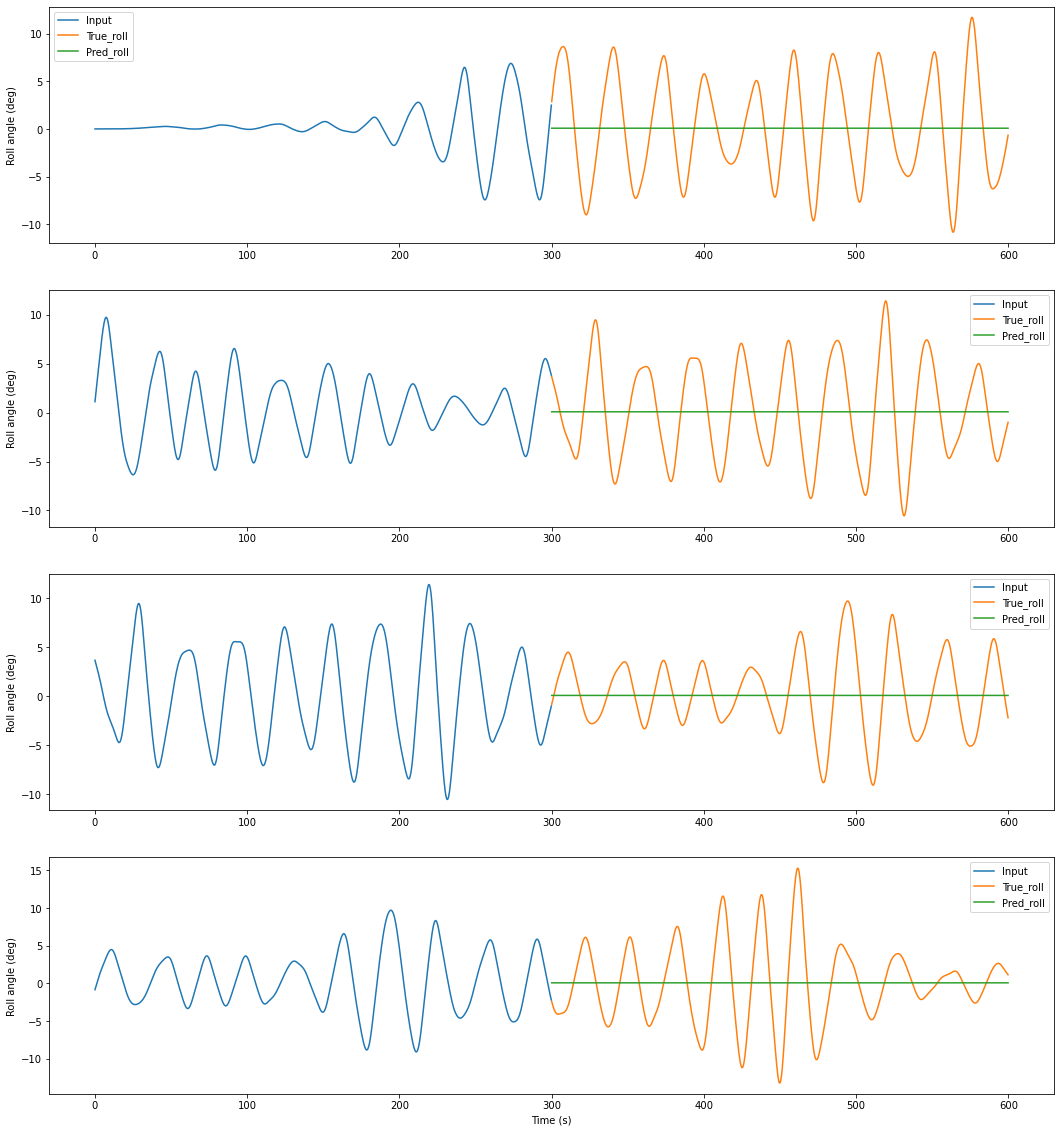

In [28]:
# plot_inference(test_in1[:,:,0], test_true1, test_pred1, nos=[0,22,24,26], cut=1)

In [16]:
# Load model

model_dir2 = 'models/RNN/05/model'

model2 = tf.keras.models.load_model(model_dir2)

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1200, 128)         68096     
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 199,809
Trainable params: 199,809
Non-trainable params: 0
_________________________________________________________________


In [17]:
val_dir2 = 'models/RNN/05/Val'
test_dir2 = 'models/RNN/05/Test'

In [18]:
test_in2, test_true2, test_pred2 = get_inference(Data_inf.Test, save_dir=test_dir2, model=model2)
val_in2, val_true2, val_pred2 = get_inference(Data_inf.Val, save_dir=val_dir2, model=model2)

KeyboardInterrupt: 

In [ ]:
save_inference(val_in2, val_true2, val_pred2, val_dir2)
save_inference(test_in2, test_true2, test_pred2, test_dir2)

In [24]:
test_in2, test_true2, test_pred2 = load_inference('models/RNN/04/Val')

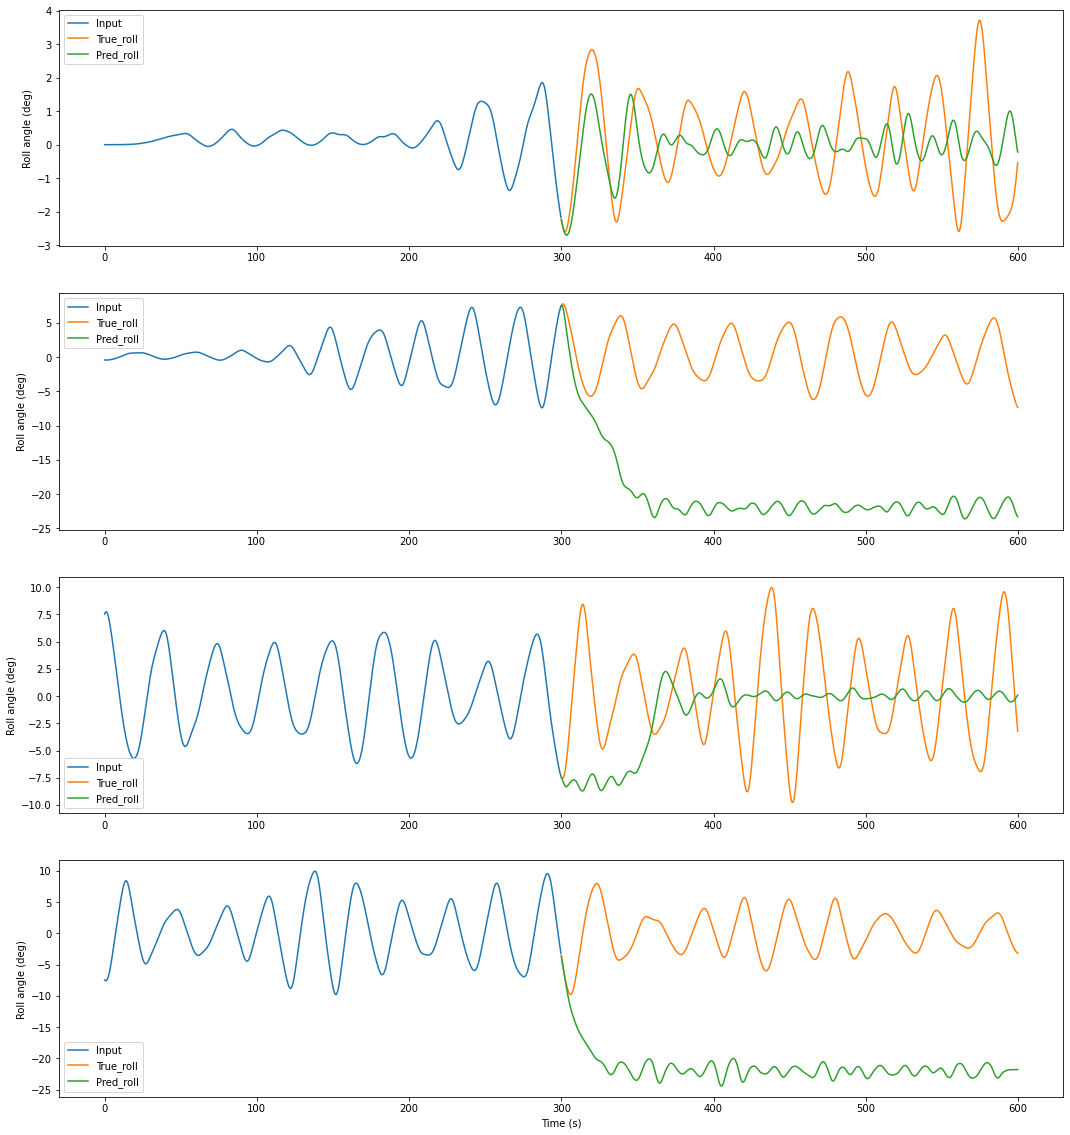

In [25]:
plot_inference(test_in2, test_true2, test_pred2, nos=[0,22,24,26], cut=1)

In [ ]:
# Load model

model_dir2 = 'models/RNN/06/model'

model2 = tf.keras.models.load_model(model_dir2)

model2.summary()

In [ ]:
val_dir2 = 'models/RNN/06/Val'
test_dir2 = 'models/RNN/06/Test'

In [ ]:
test_in2, test_true2, test_pred2 = get_inference(Data_inf.Test, save_dir=test_dir2, model=model2)
val_in2, val_true2, val_pred2 = get_inference(Data_inf.Val, save_dir=val_dir2, model=model2)

In [ ]:
save_inference(val_in2, val_true2, val_pred2, val_dir2)
save_inference(test_in2, test_true2, test_pred2, test_dir2)

In [ ]:
# plot_inference(test_in2[:,:,0], test_true2, test_pred2, nos=[0,22,24,26], cut=1)

In [ ]:
# Load model

model_dir1 = 'models/RNN/07/model'

model1 = tf.keras.models.load_model(model_dir1)

model1.summary()

In [ ]:
val_dir1 = 'models/RNN/07/Val'
test_dir1 = 'models/RNN/07/Test'

In [ ]:
test_in1, test_true1, test_pred1 = get_inference(Data_inf.Test, save_dir=test_dir1, model=model1)
val_in1, val_true1, val_pred1 = get_inference(Data_inf.Val, save_dir=val_dir1, model=model1)

In [ ]:
save_inference(val_in1, val_true1, val_pred1, val_dir1)
save_inference(test_in1, test_true1, test_pred1, test_dir1)

In [ ]:
# plot_inference(test_in1[:,:,0], test_true1, test_pred1, nos=[0,22,24,26], cut=1)

In [ ]:
# Load model

model_dir1 = 'models/RNN/08/model'

model1 = tf.keras.models.load_model(model_dir1)

model1.summary()

In [ ]:
val_dir1 = 'models/RNN/08/Val'
test_dir1 = 'models/RNN/08/Test'

In [ ]:
test_in1, test_true1, test_pred1 = get_inference(Data_inf.Test, save_dir=test_dir1, model=model1)
val_in1, val_true1, val_pred1 = get_inference(Data_inf.Val, save_dir=val_dir1, model=model1)

In [ ]:
save_inference(val_in1, val_true1, val_pred1, val_dir1)
save_inference(test_in1, test_true1, test_pred1, test_dir1)

In [ ]:
# plot_inference(test_in1[:,:,0], test_true1, test_pred1, nos=[0,22,24,26], cut=1)

In [ ]:
# Load model

model_dir1 = 'models/RNN/09/model'

model1 = tf.keras.models.load_model(model_dir1)

model1.summary()

In [ ]:
val_dir1 = 'models/RNN/09/Val'
test_dir1 = 'models/RNN/09/Test'

In [ ]:
test_in1, test_true1, test_pred1 = get_inference(Data_inf.Test, save_dir=test_dir1, model=model1)
val_in1, val_true1, val_pred1 = get_inference(Data_inf.Val, save_dir=val_dir1, model=model1)

In [ ]:
save_inference(val_in1, val_true1, val_pred1, val_dir1)
save_inference(test_in1, test_true1, test_pred1, test_dir1)

In [ ]:
# plot_inference(test_in1[:,:,0], test_true1, test_pred1, nos=[0,22,24,26], cut=1)

In [ ]:
# Load model

model_dir1 = 'models/RNN/10/model'

model1 = tf.keras.models.load_model(model_dir1)

model1.summary()

In [ ]:
val_dir1 = 'models/RNN/10/Val'
test_dir1 = 'models/RNN/10/Test'

In [ ]:
test_in1, test_true1, test_pred1 = get_inference(Data_inf.Test, save_dir=test_dir1, model=model1)
val_in1, val_true1, val_pred1 = get_inference(Data_inf.Val, save_dir=val_dir1, model=model1)

In [ ]:
save_inference(val_in1, val_true1, val_pred1, val_dir1)
save_inference(test_in1, test_true1, test_pred1, test_dir1)

In [ ]:
# plot_inference(test_in1[:,:,0], test_true1, test_pred1, nos=[0,22,24,26], cut=1)